In [22]:
import numpy as np
import bisect

## Non stationary Environment

In [23]:
class Environment():

  def __init__(self, n_arms, probabilities, bids, average_number_of_clicks, average_cum_daily_cost,noise_clicks,noise_cost):
    self.n_arms = n_arms                                            # number of prices
    self.probabilities = probabilities                              # conversion rates for every price/arm
    self.bids = bids                                                # bids
    self.average_number_of_clicks = average_number_of_clicks        # curve of average number of clicks (y = f(bids))
    self.average_cum_daily_cost = average_cum_daily_cost            # curve of cumulative daily cost (y = g(bids))
    self.noise_clicks = noise_clicks                                # gaussian noise for the average number of clicks sampling
    self.noise_cost = noise_cost                                    # gaussian noise for the cumulative daily cost sampling

  # daily rewards
  def bidding_round(self, pulled_bid):
    clicks = int(np.random.normal(self.average_number_of_clicks(self.bids[pulled_bid]),self.noise_clicks))        # number of people that click on the ad
    reward_click = clicks if clicks >= 0 else 0
    costs = np.random.normal(self.average_cum_daily_cost(self.bids[pulled_bid]),self.noise_cost)                  # cumulative daily cost
    reward_cost = costs if costs > 0 else 0

    return reward_click, reward_cost

  def pricing_round(self, pulled_price):
    reward_price = np.random.binomial(1,self.probabilities[pulled_price])                         # number of people that buy once they clicked
    return reward_price

In [24]:
class NonStationnary(Environment):
  def __init__(self, n_arms, probabilities, bids, average_number_of_clicks, average_cum_daily_cost,noise_clicks,noise_cost,
              time_abrupt_change_1, time_abrupt_change_2):
    super().__init__(n_arms, probabilities, bids, average_number_of_clicks, average_cum_daily_cost,noise_clicks,noise_cost)
    self.time_abrupt_change_1 = time_abrupt_change_1
    self.time_abrupt_change_2 = time_abrupt_change_2
    
  def pricing_round(self, pulled_price):
    print("Error: Non-stationnary environment needs the time to know the conversion rates!")
    return float("NaN")
    
  def pricing_round(self, pulled_price, time):
    if time < self.time_abrupt_change_1:
      reward_price = np.random.binomial(1,self.probabilities[0,pulled_price])
    elif time < self.time_abrupt_change_2:
      reward_price = np.random.binomial(1,self.probabilities[1,pulled_price])
    else:
      reward_price = np.random.binomial(1,self.probabilities[2,pulled_price])
    return reward_price
    

## Pricing 

In [25]:
class Learner:
  def __init__(self,n_arms):
    self.n_arms = n_arms
    self.t = 0                                              # current round value
    self.rewards_per_arm = x = [[] for i in range(n_arms)]  # value of collected rewards for each round and for each arm
    self.collected_rewards = np.array([])                   # values of collected rewards for each round

  # function that updates the observation's list once the reward is returned by the environment
  def update_observations(self, pulled_arm, reward):
    self.rewards_per_arm[pulled_arm].append(reward)
    self.collected_rewards = np.append(self.collected_rewards,reward)

In [26]:
class TS_Pricing_Learner(Learner): # Thompson-Sampling (reward: number of conversions; actual_reward:  price*conversion_rate)
  def __init__(self,n_arms,prices):
    super().__init__(n_arms)                    # number of prices
    self.beta_parameters = np.ones((n_arms,2))  # parameters of beta distributions
    self.prices = prices                        # prices (array)

    #self.empirical_means = np.zeros(n_arms)

  def pull_arm(self):
    if(self.t < self.n_arms):
      return self.t
    sampled = np.random.beta(self.beta_parameters[:,0],self.beta_parameters[:,1])*self.prices
    idx = np.argmax(sampled)
    #return idx, sampled[idx]
    return idx

  # update parameters each time a reward in {0,1} is observed
  def update(self,pulled_arm, reward):
    self.t += 1
    self.update_observations(pulled_arm,reward*self.prices[pulled_arm])
    self.beta_parameters[pulled_arm,0] = self.beta_parameters[pulled_arm,0] + reward
    self.beta_parameters[pulled_arm,1] = self.beta_parameters[pulled_arm,1] + 1 - reward

    #self.empirical_means[pulled_arm] = (self.empirical_means[pulled_arm]*(len(self.rewards_per_arm[pulled_arm]) - 1) + reward*self.prices[pulled_arm] ) / len(self.rewards_per_arm[pulled_arm])

In [27]:
class UCB_Pricing_Learner(Learner): # UCB1 (reward: number of conversions; actual_reward:  price*conversion_rate)
  def __init__(self,n_arms,prices):
    super().__init__(n_arms)                              # number of arms/prices
    self.empirical_means = np.zeros(n_arms)               # mean reward for each arm (conversion rate)
    self.confidence = np.zeros(n_arms)                    # confidence bound for each arm
    self.prices = prices                                  # prices (array)

  def pull_arm(self):
    if(self.t < self.n_arms):
      return self.t
    upper_bound = self.empirical_means + self.confidence
    pulled_arm = np.random.choice(np.where(upper_bound == upper_bound.max())[0])
    return pulled_arm

  def update(self, pulled_arm, reward):
    self.t += 1
    self.update_observations(pulled_arm, reward*self.prices[pulled_arm])
    L = len(self.rewards_per_arm[pulled_arm])
    self.empirical_means[pulled_arm] = (self.empirical_means[pulled_arm]*(L - 1) + reward*self.prices[pulled_arm] ) / L
    for a in range(self.n_arms):
      L = len(self.rewards_per_arm[a])
      self.confidence[a] = self.prices[a]*np.sqrt(2*np.log(self.t)/L) if L > 0 else 1e3

In [48]:
class CUSUM(): 
    def __init__(self, M, eps, h):
        self.M = M #used to compute reference point
        self.eps = eps
        self.h = h #treshold
        self.t = 0
        self.reference = 0
        self.g_plus = 0
        self.g_minus = 0
    
    def update (self, sample):   #compute mean before we reach M (not enough samples), after we compute variables
        self.t += 1
        if self.t <= self.M:
            self.reference += sample/self.M 
            return 0
        else:
            s_plus = (sample - self .reference) - self.eps
            s_minus = - (sample - self.reference) - self.eps
            self.g_plus = max(0, self.g_plus + s_plus)
            self.g_minus = max(0, self .g_minus + s_minus)
            return self.g_plus > self.h or self.g_minus > self.h
    def reset (self):    #resets when a change is detected
        self.t = 0
        self.g_plus = 0
        self.g_minus = 0

In [49]:
class CUSUM_UCB_Pricing_Learner(UCB_Pricing_Learner) :
    def __init__(self, n_arms, prices, M=100, eps=0.05, h=20, alpha=0.1):
        super().__init__(n_arms, prices)
        self.change_detection = [CUSUM(M, eps, h) for _ in range (n_arms)]
        self.valid_rewards_per_arm = [[] for _ in range (n_arms)]  #keeps all rewards that we have got after last CD
        self.detections = [[] for _ in range (n_arms)] #time of detection per arm
        self.alpha = alpha  #prob of taking a non optimal arm
      
    def pull_arm(self):
        if np.random.binomial (1, 1-self.alpha):
            upper_bound = self.empirical_means + self.confidence
            upper_bound [np.isinf (upper_bound)] = 1e9 #avoiding inf case
            pulled_arm = np.random.choice(np.where(upper_bound == upper_bound.max())[0])
#             print(pulled_arm)
            return pulled_arm
        else:
            pulled_arm = np.random.randint(0, self.n_arms)
#             print(pulled_arm)
            return pulled_arm
        
    def update(self, pulled_arm, reward):
        self.t += 1
        if self.change_detection[pulled_arm].update(reward):
#             print("change_detected at time:")
#             print(self.t)
#             print("on arm:")
#             print(pulled_arm)
            self.detections[pulled_arm].append (self.t)
            self.valid_rewards_per_arm[pulled_arm] =[]
            self.change_detection[pulled_arm].reset()
        self.update_observations(pulled_arm, reward*self.prices[pulled_arm])
        self.empirical_means[pulled_arm] = np.mean(self.valid_rewards_per_arm[pulled_arm])
        total_valid_samples = sum([len(x) for x in self.valid_rewards_per_arm]) 
        for a in range (self.n_arms):
            n_samples = len(self.valid_rewards_per_arm[a])
            self.confidence[a] = (2*np.log(total_valid_samples)/n_samples)**0.5 if n_samples > 0 else np.inf
                                                            
    def update_observations(self, pulled_arm, reward):
        self.rewards_per_arm[pulled_arm].append(reward)
        self.valid_rewards_per_arm [pulled_arm].append(reward)
        self.collected_rewards = np.append(self.collected_rewards, reward)
        
    def total_numofchanges(self):
        numchanges = 0
        for i in range (self.n_arms):
            numchanges += len(self.detections[i])
        return numchanges

In [28]:
class SW_UCB_Pricing_Learner(Learner): # UCB1 (reward: number of conversions; actual_reward:  price*conversion_rate)
  def __init__(self,n_arms,prices, tau):
    super().__init__(n_arms)                              # number of arms/prices
    self.empirical_means = np.zeros(n_arms)               # mean reward for each arm (conversion rate)
    self.confidence = np.zeros(n_arms)                    # confidence bound for each arm
    self.prices = prices                                  # prices (array)
    self.tau = tau                                        # parameter for the confidence bound
    self.arm_window = []                                  # window of the last arms played
    self.nb_w_samples_per_arm = [0 for _ in range(n_arms)] # number of samples in each arm window 
    self.last_reward_arm_out = -1                         # last arm that went out of the arm window
  
  def empirical_means_in_range(self, pulled_arm):
    count = self.nb_w_samples_per_arm[pulled_arm]  
    return sum(self.rewards_per_arm[pulled_arm])/count if count > 0 else 1e3

  def pull_arm(self):
    if(self.t < self.n_arms):
      return self.t
    
    for a in range(self.n_arms):
      if self.nb_w_samples_per_arm[a] == 0:
        return a

    upper_bound = self.empirical_means + self.confidence
    pulled_arm = np.random.choice(np.where(upper_bound == upper_bound.max())[0])
    return pulled_arm

  def update_observations(self, pulled_arm, reward):
    self.arm_window.append(pulled_arm)
    self.rewards_per_arm[pulled_arm].append(reward)
    self.nb_w_samples_per_arm[pulled_arm] += 1
    if self.t > self.tau:
      self.last_reward_arm_out = self.arm_window.pop(0)
      self.rewards_per_arm[self.last_reward_arm_out].pop(0)
      self.nb_w_samples_per_arm[self.last_reward_arm_out] -= 1
    
    self.collected_rewards = np.append(self.collected_rewards,reward)

  def update(self, pulled_arm, reward):
    self.t += 1
    self.update_observations(pulled_arm, reward*self.prices[pulled_arm])
    self.empirical_means[pulled_arm] = self.empirical_means_in_range(pulled_arm)
    # keep update the empirical means of the last arm that went out of the arm window
    if (self.last_reward_arm_out != -1):
      self.empirical_means[self.last_reward_arm_out] = self.empirical_means_in_range(self.last_reward_arm_out)
    for a in range(self.n_arms):
      nb_samples_t_1_tau = self.nb_w_samples_per_arm[a]
      if (a == pulled_arm):
        nb_samples_t_1_tau -= 1 
      if (a == self.last_reward_arm_out):
        nb_samples_t_1_tau += 1
      self.confidence[a] = self.prices[a]*np.sqrt(2*np.log(self.t)/nb_samples_t_1_tau) if nb_samples_t_1_tau > 0 else 1e3

## Simulation

In [29]:
import matplotlib.pyplot as plt
from tqdm import tqdm

In [30]:
# generic
T = 365                                # horizon of experiment
n_experiments = 100                    # since the reward functions are stochastic, to better visualize the results and remove the noise we do multiple experiments

In [31]:
# pricing
n_prices = 5
prices = [5,6,7,8,9]
p = np.array([[0.4,0.6,0.2,0.1,0.1],
              [0.2,0.3,0.3,0.5,0.7],
              [0.4,0.5,0.8,0.4,0.1]])             # bernoulli distributions for the reward functions

time_abrupt_change_1 = 92
time_abrupt_change_2 = 92+150
opt_rate_0 = p[0, np.argmax(p[0,:]*prices)]                 # optimal arm
opt_rate_1 = p[1, np.argmax(p[1,:]*prices)] 
opt_rate_2 = p[2, np.argmax(p[2,:]*prices)] 
print("Pricing (optimal price):")
print("Before change:")
print(" idx: " + str(np.argmax(p[0,:]*prices)) + 
      "  price: " + str(prices[np.argmax(p[0,:]*prices)]) + 
      "  rate: " + str(opt_rate_0) + 
      "  price*rate: " + str(opt_rate_0*prices[np.argmax(p[0,:]*prices)]))
print("After 1 change:")
print(" idx: " + str(np.argmax(p[1,:]*prices)) + 
      "  price: " + str(prices[np.argmax(p[1,:]*prices)]) + 
      "  rate: " + str(opt_rate_1) + 
      "  price*rate: " + str(opt_rate_1*prices[np.argmax(p[1,:]*prices)]))
print("After 2 changes:")
print(" idx: " + str(np.argmax(p[2,:]*prices)) + 
      "  price: " + str(prices[np.argmax(p[2,:]*prices)]) + 
      "  rate: " + str(opt_rate_2) + 
      "  price*rate: " + str(opt_rate_2*prices[np.argmax(p[2,:]*prices)]))

Pricing (optimal price):
Before change:
 idx: 1  price: 6  rate: 0.6  price*rate: 3.5999999999999996
After 1 change:
 idx: 4  price: 9  rate: 0.7  price*rate: 6.3
After 2 changes:
 idx: 2  price: 7  rate: 0.8  price*rate: 5.6000000000000005


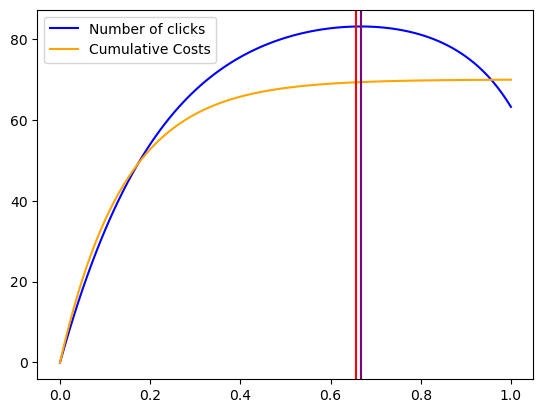

In [32]:
# advertising
n_bids = 100
min_bid = 0.0
max_bid = 1.0
bids = np.linspace(min_bid, max_bid, n_bids)
sigma_clicks = 3
sigma_costs = 3
def clicks(x):
  return 100 * (1.0 - np.exp(-4*x+3*x**3))
def costs(x):
  return 70 * (1.0 - np.exp(-7*x))
opt_bid_0 = bids[np.argmax(opt_rate_0*prices[np.argmax(p[0,:]*prices)]*clicks(bids)-costs(bids))]
opt_bid_1 = bids[np.argmax(opt_rate_1*prices[np.argmax(p[1,:]*prices)]*clicks(bids)-costs(bids))]
opt_bid_2 = bids[np.argmax(opt_rate_2*prices[np.argmax(p[2,:]*prices)]*clicks(bids)-costs(bids))]
fig, ax = plt.subplots()
ax.plot(bids,clicks(bids),'blue',bids,costs(bids),'orange')
ax.legend(["Number of clicks", "Cumulative Costs"])
ax.axvline(opt_bid_0,c='red')
ax.axvline(opt_bid_1,c='green')
ax.axvline(opt_bid_2,c='purple')
# print("Advertising (optimal bid):")
# print("idx: " + str(np.argmax(opt_rate*prices[np.argmax(p*prices)]*clicks(bids)-costs(bids))) + "  bid: " + str(opt_bid) + "  clicks-costs: " + str(clicks(opt_bid)-costs(opt_bid)))

## UCB

In [52]:
n_experiments = 10  

ucb_rewards_per_experiment_t = []
for e in tqdm(range(n_experiments)):
    env = NonStationnary(n_arms = n_prices,
                       probabilities = p,
                       bids = bids,
                       average_number_of_clicks = clicks,
                       average_cum_daily_cost = costs,
                       noise_clicks = sigma_clicks,
                       noise_cost = sigma_costs,
                       time_abrupt_change_1 = time_abrupt_change_1,
                       time_abrupt_change_2 = time_abrupt_change_2)

    ucb_learner = UCB_Pricing_Learner(n_prices, prices)

    ucb_collected_costs = np.array([])
    ucb_daily_pricing_reward = np.array([])
        
    for t in range(T):
        # UCB
        pulled_bid = np.argmax(clicks(bids)-costs(bids))
        reward_click, reward_cost = env.bidding_round(pulled_bid)
        ucb_collected_costs = np.append(ucb_collected_costs, reward_cost)
        for k in range(reward_click):
            pulled_price = ucb_learner.pull_arm()
            reward_price = env.pricing_round(pulled_price, t)
            ucb_learner.update(pulled_price, reward_price)
        ucb_daily_pricing_reward = np.append(ucb_daily_pricing_reward,(reward_click>0)*np.sum(ucb_learner.collected_rewards[-reward_click:]))
    
    ucb_rewards_per_experiment_t.append(ucb_daily_pricing_reward-ucb_collected_costs)

## Sliding window

## $\tau$ Influence

In [68]:
def generate_logarithmic_array(start, end, size):
    x = np.linspace(0, 1, size)  # Generate a sequence of 20 points between 0 and 1
    values = np.exp(x * np.log(end / start))  # Apply the logarithmic transformation
    values = start + (end - start) * (values - np.min(values)) / (np.max(values) - np.min(values))  # Rescale the values between start and end
    return values  # Convert the values to integers

In [45]:
n_experiments = 10  

taus = generate_logarithmic_array(100,50000,10)

sw_ucb_rewards_per_experiment_per_tau = []

for tau in tqdm(taus):
    sw_ucb_rewards_per_experiment = []
#     ucb_rewards_per_experiment_t = []
    for e in range(n_experiments):
        env = NonStationnary(n_arms = n_prices,
                       probabilities = p,
                       bids = bids,
                       average_number_of_clicks = clicks,
                       average_cum_daily_cost = costs,
                       noise_clicks = sigma_clicks,
                       noise_cost = sigma_costs,
                       time_abrupt_change_1 = time_abrupt_change_1,
                       time_abrupt_change_2 = time_abrupt_change_2)
        sw_ucb_learner = SW_UCB_Pricing_Learner(n_prices, prices, int(tau))

#         ucb_learner = UCB_Pricing_Learner(n_prices, prices)

        sw_ucb_collected_costs = np.array([])
        sw_ucb_daily_pricing_reward = np.array([])

#         ucb_collected_costs = np.array([])
#         ucb_daily_pricing_reward = np.array([])
        
        for t in range(T):
            pulled_bid = np.argmax(clicks(bids)-costs(bids))
            reward_click, reward_cost = env.bidding_round(pulled_bid)
            sw_ucb_collected_costs = np.append(sw_ucb_collected_costs, reward_cost)
            for k in range(reward_click):
                pulled_price = sw_ucb_learner.pull_arm()
                reward_price = env.pricing_round(pulled_price, t)
                sw_ucb_learner.update(pulled_price, reward_price)
            sw_ucb_daily_pricing_reward = np.append(sw_ucb_daily_pricing_reward,(reward_click>0)*np.sum(sw_ucb_learner.collected_rewards[-reward_click:]))

#             # UCB
#             pulled_bid = np.argmax(clicks(bids)-costs(bids))
#             reward_click, reward_cost = env.bidding_round(pulled_bid)
#             ucb_collected_costs = np.append(ucb_collected_costs, reward_cost)
#             for k in range(reward_click):
#                 pulled_price = ucb_learner.pull_arm()
#                 reward_price = env.pricing_round(pulled_price, t)
#                 ucb_learner.update(pulled_price, reward_price)
#             ucb_daily_pricing_reward = np.append(ucb_daily_pricing_reward,(reward_click>0)*np.sum(ucb_learner.collected_rewards[-reward_click:]))
    
        sw_ucb_rewards_per_experiment.append(sw_ucb_daily_pricing_reward-sw_ucb_collected_costs)
#         ucb_rewards_per_experiment_t.append(ucb_daily_pricing_reward-ucb_collected_costs)
    sw_ucb_rewards_per_experiment_per_tau.append(sw_ucb_rewards_per_experiment)

100%|██████████| 10/10 [09:54<00:00, 59.42s/it]


In [46]:
opt_0 = [opt_rate_0*prices[np.argmax(p[0,:]*prices)]*clicks(opt_bid_0) - costs(opt_bid_0) 
         for i in range(time_abrupt_change_1)]
opt_1 = [opt_rate_1*prices[np.argmax(p[1,:]*prices)]*clicks(opt_bid_1) - costs(opt_bid_1) 
         for i in range(time_abrupt_change_2-time_abrupt_change_1)]
opt_2 = [opt_rate_2*prices[np.argmax(p[2,:]*prices)]*clicks(opt_bid_2) - costs(opt_bid_2) 
         for i in range(T-time_abrupt_change_2)]
opt = np.array(opt_0 + opt_1 + opt_2)

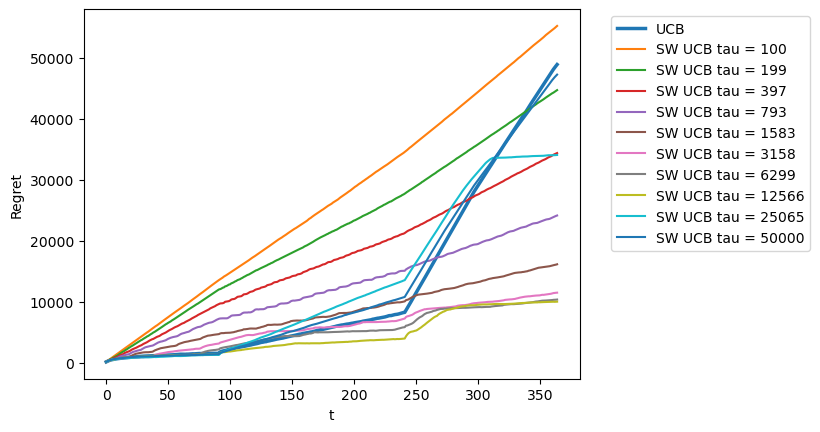

In [47]:
plt.figure(0)
plt.ylabel("Regret")
plt.xlabel("t")

plt.plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment_t, axis=0)), linewidth=2.5)
for i in range(0, len(taus)):
    cumsum = np.cumsum(np.mean(opt - sw_ucb_rewards_per_experiment_per_tau[i], axis=0))
    plt.plot(cumsum)
plt.legend(["UCB"] + ["SW UCB tau = " + str(taus[i]) for i in range(0, len(taus))], bbox_to_anchor=(1.05, 1), loc='upper left')

## Change direction

## M Influence

In [60]:
n_experiments = 10

Ms = generate_logarithmic_array(10,50000,5)

eps = 0.0771886247934499
h = 8.901757699412148
alpha = 0.002830372497030649

cusum_rewards_per_experiment_per_M = []

for M in tqdm(Ms):
    cusum_rewards_per_experiment = []
    for e in range(n_experiments):
        env = NonStationnary(n_arms = n_prices,
                       probabilities = p,
                       bids = bids,
                       average_number_of_clicks = clicks,
                       average_cum_daily_cost = costs,
                       noise_clicks = sigma_clicks,
                       noise_cost = sigma_costs,
                       time_abrupt_change_1 = time_abrupt_change_1,
                       time_abrupt_change_2 = time_abrupt_change_2)
        cusum_learner = CUSUM_UCB_Pricing_Learner(n_arms = n_prices, prices = prices, M = int(M), eps=eps, h=h, alpha=alpha)

        cusum_collected_costs = np.array([])
        cusum_daily_pricing_reward = np.array([])
        
        for t in range(T):
            pulled_bid = np.argmax(clicks(bids)-costs(bids))
            reward_click, reward_cost = env.bidding_round(pulled_bid)
            cusum_collected_costs = np.append(cusum_collected_costs, reward_cost)
            for k in range(reward_click):
                pulled_price = cusum_learner.pull_arm()
                reward_price = env.pricing_round(pulled_price, t)
                cusum_learner.update(pulled_price, reward_price)
            cusum_daily_pricing_reward = np.append(cusum_daily_pricing_reward,
                                                   (reward_click>0)*np.sum(cusum_learner.collected_rewards[-reward_click:]))
    
        cusum_rewards_per_experiment.append(cusum_daily_pricing_reward-cusum_collected_costs)
    cusum_rewards_per_experiment_per_M.append(cusum_rewards_per_experiment)

100%|██████████| 5/5 [07:56<00:00, 95.30s/it] 


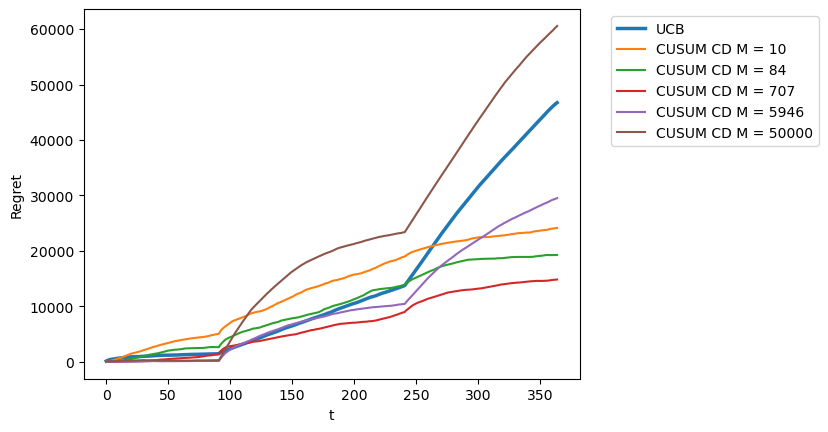

In [61]:
plt.figure(0)
plt.ylabel("Regret")
plt.xlabel("t")

plt.plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment_t, axis=0)), linewidth=2.5)
for i in range(0, len(Ms)):
    cumsum = np.cumsum(np.mean(opt - cusum_rewards_per_experiment_per_M[i], axis=0))
    plt.plot(cumsum)
plt.legend(["UCB"] + ["CUSUM CD M = " + str(Ms[i]) for i in range(0, len(Ms))], bbox_to_anchor=(1.05, 1), loc='upper left')

## $\epsilon$ Influence

In [72]:
n_experiments = 10

M = 105

epsilon = generate_logarithmic_array(1e-4,10,5)

h = 8.901757699412148
alpha = 0.002830372497030649

cusum_rewards_per_experiment_per_M = []

for eps in tqdm(epsilon):
    cusum_rewards_per_experiment = []
    for e in range(n_experiments):
        env = NonStationnary(n_arms = n_prices,
                       probabilities = p,
                       bids = bids,
                       average_number_of_clicks = clicks,
                       average_cum_daily_cost = costs,
                       noise_clicks = sigma_clicks,
                       noise_cost = sigma_costs,
                       time_abrupt_change_1 = time_abrupt_change_1,
                       time_abrupt_change_2 = time_abrupt_change_2)
        cusum_learner = CUSUM_UCB_Pricing_Learner(n_arms = n_prices, prices = prices, M = M, eps=eps, h=h, alpha=alpha)

        cusum_collected_costs = np.array([])
        cusum_daily_pricing_reward = np.array([])
        
        for t in range(T):
            pulled_bid = np.argmax(clicks(bids)-costs(bids))
            reward_click, reward_cost = env.bidding_round(pulled_bid)
            cusum_collected_costs = np.append(cusum_collected_costs, reward_cost)
            for k in range(reward_click):
                pulled_price = cusum_learner.pull_arm()
                reward_price = env.pricing_round(pulled_price, t)
                cusum_learner.update(pulled_price, reward_price)
            cusum_daily_pricing_reward = np.append(cusum_daily_pricing_reward,
                                                   (reward_click>0)*np.sum(cusum_learner.collected_rewards[-reward_click:]))
    
        cusum_rewards_per_experiment.append(cusum_daily_pricing_reward-cusum_collected_costs)
    cusum_rewards_per_experiment_per_M.append(cusum_rewards_per_experiment)

100%|██████████| 5/5 [07:54<00:00, 94.83s/it] 


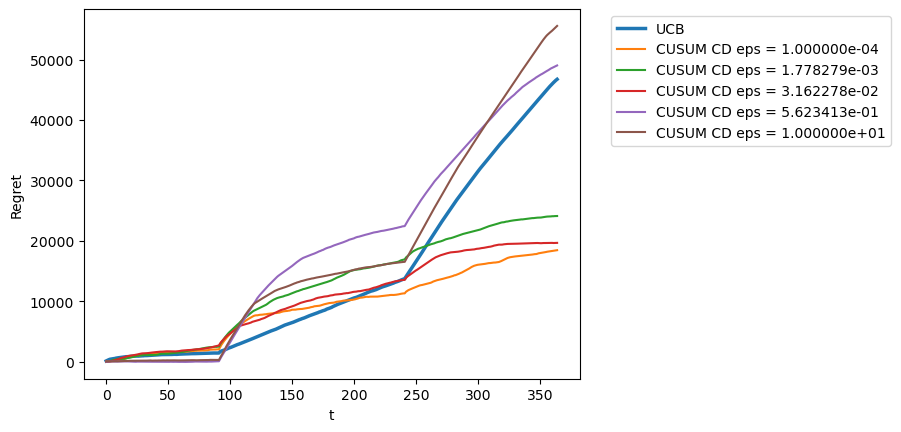

In [73]:
plt.figure(0)
plt.ylabel("Regret")
plt.xlabel("t")

plt.plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment_t, axis=0)), linewidth=2.5)
for i in range(0, len(epsilon)):
    cumsum = np.cumsum(np.mean(opt - cusum_rewards_per_experiment_per_M[i], axis=0))
    plt.plot(cumsum)
# plt.legend(["UCB"] + ["CUSUM CD eps = " + str(epsilon[i]) for i in range(0, len(epsilon))], 
#            bbox_to_anchor=(1.05, 1), loc='upper left')

"{:e}".format(epsilon[i])
plt.legend(["UCB"] + ["CUSUM CD eps = " + "{:e}".format(epsilon[i]) for i in range(0, len(epsilon))], 
           bbox_to_anchor=(1.05, 1), loc='upper left')

## h Influence

In [76]:
n_experiments = 10

M = 105
eps = 0.0771886247934499

hs = generate_logarithmic_array(1,100,5)

alpha = 0.002830372497030649

cusum_rewards_per_experiment_per_M = []

for h in tqdm(hs):
    cusum_rewards_per_experiment = []
    for e in range(n_experiments):
        env = NonStationnary(n_arms = n_prices,
                       probabilities = p,
                       bids = bids,
                       average_number_of_clicks = clicks,
                       average_cum_daily_cost = costs,
                       noise_clicks = sigma_clicks,
                       noise_cost = sigma_costs,
                       time_abrupt_change_1 = time_abrupt_change_1,
                       time_abrupt_change_2 = time_abrupt_change_2)
        cusum_learner = CUSUM_UCB_Pricing_Learner(n_arms = n_prices, prices = prices, M = M, eps=eps, h=h, alpha=alpha)

        cusum_collected_costs = np.array([])
        cusum_daily_pricing_reward = np.array([])
        
        for t in range(T):
            pulled_bid = np.argmax(clicks(bids)-costs(bids))
            reward_click, reward_cost = env.bidding_round(pulled_bid)
            cusum_collected_costs = np.append(cusum_collected_costs, reward_cost)
            for k in range(reward_click):
                pulled_price = cusum_learner.pull_arm()
                reward_price = env.pricing_round(pulled_price, t)
                cusum_learner.update(pulled_price, reward_price)
            cusum_daily_pricing_reward = np.append(cusum_daily_pricing_reward,
                                                   (reward_click>0)*np.sum(cusum_learner.collected_rewards[-reward_click:]))
    
        cusum_rewards_per_experiment.append(cusum_daily_pricing_reward-cusum_collected_costs)
    cusum_rewards_per_experiment_per_M.append(cusum_rewards_per_experiment)

100%|██████████| 5/5 [06:08<00:00, 73.62s/it]


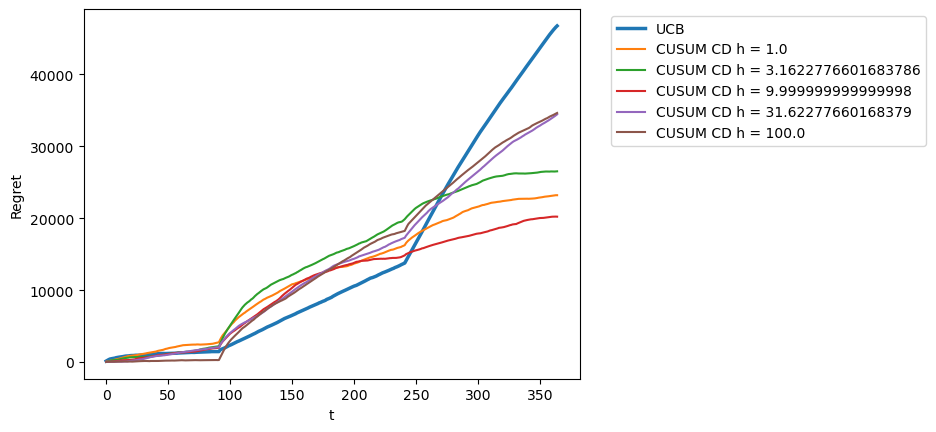

In [77]:
plt.figure(0)
plt.ylabel("Regret")
plt.xlabel("t")

plt.plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment_t, axis=0)), linewidth=2.5)
for i in range(0, len(hs)):
    cumsum = np.cumsum(np.mean(opt - cusum_rewards_per_experiment_per_M[i], axis=0))
    plt.plot(cumsum)
plt.legend(["UCB"] + ["CUSUM CD h = " + str(hs[i]) for i in range(0, len(hs))], bbox_to_anchor=(1.05, 1), loc='upper left')

## $\alpha$ Influence

In [ ]:
n_experiments = 1

M = 105

eps = 0.0771886247934499
h = 8.901757699412148
alphas = generate_logarithmic_array(1e-4,1,5)

cusum_rewards_per_experiment_per_M = []

for alpha in tqdm(alphas):
    cusum_rewards_per_experiment = []
    for e in range(n_experiments):
        env = NonStationnary(n_arms = n_prices,
                       probabilities = p,
                       bids = bids,
                       average_number_of_clicks = clicks,
                       average_cum_daily_cost = costs,
                       noise_clicks = sigma_clicks,
                       noise_cost = sigma_costs,
                       time_abrupt_change_1 = time_abrupt_change_1,
                       time_abrupt_change_2 = time_abrupt_change_2)
        cusum_learner = CUSUM_UCB_Pricing_Learner(n_arms = n_prices, prices = prices, M = M, eps=eps, h=h, alpha=alpha)

        cusum_collected_costs = np.array([])
        cusum_daily_pricing_reward = np.array([])
        
        for t in range(T):
            pulled_bid = np.argmax(clicks(bids)-costs(bids))
            reward_click, reward_cost = env.bidding_round(pulled_bid)
            cusum_collected_costs = np.append(cusum_collected_costs, reward_cost)
            for k in range(reward_click):
                pulled_price = cusum_learner.pull_arm()
                reward_price = env.pricing_round(pulled_price, t)
                cusum_learner.update(pulled_price, reward_price)
            cusum_daily_pricing_reward = np.append(cusum_daily_pricing_reward,
                                                   (reward_click>0)*np.sum(cusum_learner.collected_rewards[-reward_click:]))
    
        cusum_rewards_per_experiment.append(cusum_daily_pricing_reward-cusum_collected_costs)
    cusum_rewards_per_experiment_per_M.append(cusum_rewards_per_experiment)

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
plt.figure(0)
plt.ylabel("Regret")
plt.xlabel("t")

plt.plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment_t, axis=0)), linewidth=2.5)
for i in range(0, len(alphas)):
    cumsum = np.cumsum(np.mean(opt - cusum_rewards_per_experiment_per_M[i], axis=0))
    plt.plot(cumsum)
plt.legend(["UCB"] + ["CUSUM CD alpha = " + str(alphas[i]) for i in range(0, len(alphas))], bbox_to_anchor=(1.05, 1), loc='upper left')